# Implementing a LIF in JAX

In this tutorial we'll implement a Leaky Integrate-and-Fire (LIF) neuron in JAX. If you haven't read the theory yet, check out the [LIF theory tutorial](/posts/2025/10/lif-theory/) first.

## Quick refresher
The LIF's state $U[t]$ is governed by:

$$
U[t] = \underbrace{\alpha U[t-1]}_{\text{decayed state}} + \underbrace{W X[t]}_{\text{weighted input}} - \underbrace{S[t-1] \theta}_{\text{reset}}
$$

The firing mechanism:

$$
S[t] = \Theta(U[t] - \theta)
$$

where $\Theta$ is the Heaviside step function.

## The basic architecture
LIFs have **parameters** (like decay constant $\alpha$, weight $W$, and threshold $\theta$) that don't change often, and **state** (membrane potential $u[t]$ and spike output $s[t]$) that changes every timestep.

JAX is built around **pure functions**. Instead of neurons as objects that change over time, we run a function on a state to receive a new state. The function doesn't keep track of anything—it just transforms one state to another.

In [1]:
from typing import NamedTuple
from jax import Array

class LIFParams(NamedTuple):
    alpha: Array
    W: Array
    theta: Array

## Defining LIF Parameters

Let's start by defining the parameters that characterize our LIF neurons:
- **Decay constant** $\alpha$: Controls how fast the membrane potential decays
- **Weight matrix** $W$: Incoming connection weights for each neuron
- **Threshold** $\theta$: Firing threshold

We'll use JAX's `NamedTuple` which is a PyTree—a structure that JAX can efficiently traverse for vectorization and automatic differentiation.

In [2]:
import jax.numpy as jnp

alpha = jnp.array([0.9])
W = jnp.array([[0.4]])
theta = jnp.array([1.0])
params = LIFParams(alpha, W, theta)

In [3]:
print(params)

LIFParams(alpha=Array([0.9], dtype=float32), W=Array([[0.4]], dtype=float32), theta=Array([1.], dtype=float32))


In [4]:
class LIFState(NamedTuple):
    u: Array
    spike: Array

u = jnp.array([0.0])
spike = jnp.array([0.0])
state = LIFState(u, spike)

## Defining LIF State

While parameters stay constant during inference, the **state** changes at every timestep. The state consists of:
- **Membrane potential** $u[t]$: The current voltage of each neuron
- **Spike output** $s[t]$: Whether each neuron fired (1) or not (0)

Let's define the state structure and initialize it to zero:

In [5]:
print("current state", state)

current state LIFState(u=Array([0.], dtype=float32), spike=Array([0.], dtype=float32))


In [6]:
def lif_step(
    params: LIFParams,
    state: LIFState,
    inputs: jnp.ndarray,
):
    decayed_state = params.alpha * state.u
    weighted_input = inputs @ params.W
    reset = state.spike * params.theta
    u_new = decayed_state + weighted_input - reset
    spike = jnp.heaviside(u_new - params.theta, 0)

    return LIFState(u=u_new, spike=spike)

## The Step Function

Now we need a function to update the neuron's state. This implements the LIF dynamics:

1. **Decay** the previous membrane potential: $\alpha \cdot u[t-1]$
2. **Add weighted input**: $W \cdot x[t]$
3. **Reset** if spiked: $- s[t-1] \cdot \theta$
4. **Check threshold** and generate spikes: $s[t] = \Theta(u[t] - \theta)$

The function is **pure**—it takes the current state and returns a new state without side effects:

In [7]:
inputs = jnp.array([1])
new_state = lif_step(params, state, inputs)
print("new state", new_state)

new state LIFState(u=Array([0.4], dtype=float32), spike=Array([0.], dtype=float32))


## Testing the Step Function

Let's test our `lif_step` function with a single input spike. With $W = 0.4$ and an input of 1, we should see the membrane potential increase to 0.4 (below threshold, so no spike):

In [8]:
import matplotlib.pyplot as plt

def plot_lif_simulation(state_history, inputs, params: LIFParams, filename: str = 'lif_simulation.svg'):
    """
    Create a 3-part plot showing:
    1. Membrane potential over time
    2. Incoming spikes
    3. Outgoing spikes

    Args:
        state_history: List of LIFState objects
        inputs: Array of input spikes (n_steps, n_inputs)
        params: LIFParams containing theta for threshold line
        filename: Output filename for the plot
    """
    # Extract data for plotting
    u_history = jnp.array([s.u[0] for s in state_history])
    spike_history = jnp.array([s.spike[0] for s in state_history])
    input_spikes = inputs.squeeze()
    n_steps = len(state_history)

    # Create 3-part plot with aligned time axes
    _, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    time_steps = jnp.arange(n_steps)

    # Plot membrane potential
    axes[0].plot(time_steps, u_history, 'b-', linewidth=1.5)
    axes[0].axhline(y=params.theta[0], color='r', linestyle='--', label='Threshold')
    axes[0].set_ylabel('Membrane Potential (u)', fontsize=11)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot incoming spikes
    axes[1].axhline(y=0, color='gray', linewidth=1, alpha=0.7)
    spike_times_in = time_steps[input_spikes > 0]
    axes[1].vlines(spike_times_in, 0, 0.8, colors='green', linewidths=2)
    axes[1].set_ylabel('Incoming Spikes', fontsize=11)
    axes[1].set_ylim([-0.1, 1])
    axes[1].set_yticks([])
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].grid(True, alpha=0.3, axis='x')

    # Plot outgoing spikes
    axes[2].axhline(y=0, color='gray', linewidth=1, alpha=0.7)
    spike_times_out = time_steps[spike_history > 0]
    axes[2].vlines(spike_times_out, 0, 0.8, colors='red', linewidths=2)
    axes[2].set_ylabel('Outgoing Spikes', fontsize=11)
    axes[2].set_xlabel('Time Step', fontsize=11)
    axes[2].set_ylim([-0.1, 1])
    axes[2].set_yticks([])
    axes[2].spines['top'].set_visible(False)
    axes[2].spines['right'].set_visible(False)
    axes[2].spines['left'].set_visible(False)
    axes[2].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Plot saved to {filename}")
    plt.show()

In [9]:
from jax import random

current_state = LIFState(u=jnp.array([0.0]), spike=jnp.array([0.0]))
key = random.PRNGKey(3)
n_steps = 100
inputs = random.bernoulli(key, p=0.15, shape=(n_steps, 1))

state_history = []
for i in range(n_steps):
    current_state = lif_step(params, current_state, inputs[i])
    state_history.append(current_state)

## Running a Simulation

It works! Now let's see how the LIF behaves over time with random input spikes. We'll generate 100 timesteps of inputs with a 15% spike probability and track the state history:

*Note: This loop approach is inefficient—we'll optimize it with `scan` shortly.*

Plot saved to lif_simulation.svg


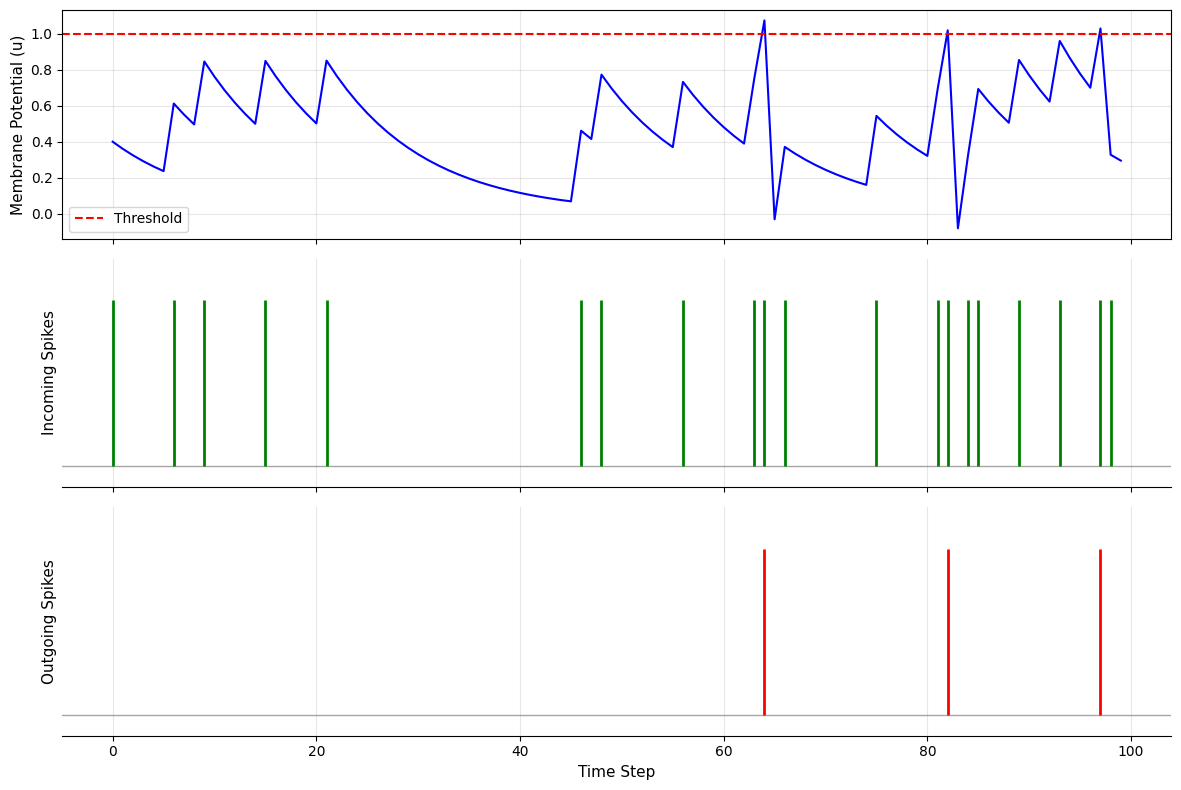

In [10]:
plot_lif_simulation(state_history, inputs, params)

## Visualizing the Simulation

Let's plot the simulation to see:
1. **Membrane potential** rising with inputs and decaying over time
2. **Incoming spikes** (green vertical lines)
3. **Outgoing spikes** (red vertical lines) when the membrane potential crosses the threshold

In [11]:
from jax.lax import scan
from functools import partial

def lif_scan_wrapper(params: LIFParams, state: LIFState, inputs: jnp.ndarray):
    new_state = lif_step(params, state, inputs)
    return new_state, new_state  # carry, append_for_history

bound_step = partial(lif_scan_wrapper, params)
final_state, state_history = scan(bound_step, state, inputs)

## Optimizing with the Scan Method

The Python `for` loop above is inefficient. JAX's `jax.lax.scan` allows us to iterate much more efficiently by compiling the entire loop.

The `scan` function requires:
- A **wrapper function** that processes one timestep
- A **carry** value that gets passed forward (our LIF state)
- An **accumulator** for values we want to keep (state history)

The wrapper returns `(new_carry, value_to_append)`. We use `partial` to bind the parameters to our function:

For more details on `scan`, check out [A Friendly Introduction to Scan with JAX](https://www.nelsontang.com/blog/a-friendly-introduction-to-scan-with-jax).

In [12]:
print("final state", final_state)

final state LIFState(u=Array([0.2947328], dtype=float32), spike=Array([0.], dtype=float32))


**Note:** The `state_history` returned by `scan` is different from our Python loop version. Instead of a list of `LIFState` objects, it's a single `LIFState` where each field (`.u` and `.spike`) is now an array containing all values over time. This is JAX's efficient way of handling sequences!